In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
import yaml
import sys
import glob
import os
%matplotlib inline

In [2]:
sns.set(font_scale=1.1, style='white')
sns_cmap = sns.color_palette().as_hex()

In [3]:
def sum_cpu(node_res):
    """Return sum of CPU resources allocated to all nodes"""
    cpu = sum([v['cpu'] for v in node_res])
    return cpu

def read_placement(placement, df_data, flow_dr=250):
    """Read placement dict and write it to df_data. Then return."""
    df_data['num_flows'].append(placement['input']['num_flows'])
    df_data['num_sources'].append(placement['input']['num_sources'])
    df_data['source_dr'].append(placement['input']['num_flows'] * flow_dr)
    df_data['num_instances'].append(placement['metrics']['num_instances'])
    df_data['max_e2e_delay'].append(placement['metrics']['max_endToEnd_delay'])
    df_data['total_delay'].append(placement['metrics']['total_delay'])
    df_data['runtime'].append(placement['metrics']['runtime'])
    df_data['total_cpu'].append(sum_cpu(placement['placement']['alloc_node_res']))
    return df_data

def read_results(results):
    """Read result files matching the pattern and return df containing their metrics"""
    data = {'num_sources' : [], 'num_flows': [], 'source_dr': [], 'num_instances': [], 
            'max_e2e_delay': [], 'total_delay': [], 'runtime': [], 'total_cpu': []}

    # iterate through result files
    for res in glob.glob(results):
        # open and save metrics of interest
        with open(res, 'r') as f:
            placement = yaml.load(f, Loader=yaml.SafeLoader)
            data = read_placement(placement, data)

    return pd.DataFrame(data).sort_values(by=['num_flows'])

In [4]:
# read results
# graph = '
dataset = 'synth_data'
sources = 'single_src_dr1'
results = f'placement_data/{dataset}/{sources}/'

# df_true = read_results(results + 'true/*.yaml')
# df_fixed = read_results(results + 'fixed_0.6/*.yaml')
# df_linear = read_results(results + 'linear/*.yaml')
# df_boost = read_results(results + 'boosting/*.yaml')
# df_svr = read_results(results + 'svr/*.yaml')
# df_ml = read_results(results + 'ml/*.yaml')
df_cen = read_results(results + 'new_data_centralized_model_0.28_40_epochs/*.yaml')
df_fed = read_results(results + 'new_data_federated_model_0.42_20_epochs/*.yaml')

In [5]:
df_cen.head()

,num_sources,num_flows,source_dr,num_instances,max_e2e_delay,total_delay,runtime,total_cpu
5,1,1,250,3,20,20,9.919615,0.117096
4,1,2,500,3,20,20,19.209154,0.154416
0,1,3,750,3,20,20,28.370883,0.191735
1,1,4,1000,3,20,20,37.227066,0.229055
3,1,5,1250,3,20,20,43.338997,0.365628


In [6]:
df_fixed

NameError: name 'df_fixed' is not defined

In [7]:
df_fed

,num_sources,num_flows,source_dr,num_instances,max_e2e_delay,total_delay,runtime,total_cpu
4,1,1,250,3,20,20,9.819096,0.230257
5,1,2,500,3,20,20,17.786830,0.397259
3,1,3,750,3,20,20,24.912620,0.562227
2,1,4,1000,3,20,20,36.001022,0.727196
1,1,5,1250,3,20,20,48.971816,0.892165
0,1,6,1500,3,21,21,62.710773,1.057134


In [106]:
def plot(df_fed, df_cen, df_fixed, x_col, x_label, y_col, y_label, save_plot=True, plot_fixed=True):
    sns.set(font_scale=1.1, style='white')
    fig, ax = plt.subplots()

    # use fixed colors for consistency with other plots (and more models)
#     plt.plot(df_true[x_col], df_true[y_col], label='True', color='black', marker='o')
    if plot_fixed:
        plt.plot(df_fixed[x_col], df_fixed[y_col], label='Fixed', color='red',
                 linewidth=3, markersize=10, markeredgewidth=1.5)
    plt.plot(df_cen[x_col], df_cen[y_col], label='NN Centralised', color='green',
             linewidth=2, markersize=7, markeredgewidth=1.5)
    plt.plot(df_fed[x_col], df_fed[y_col], label='NN Federated', color='navy',
             linewidth=2, markersize=7, markeredgewidth=1.5)
#     plt.plot(df_boost[x_col], df_boost[y_col], label='Boosting', color='red', marker='^')
#     plt.plot(df_svr[x_col], df_svr[y_col], label='SVR', color='orange', marker='v')
    # plt.plot(df_ml[x_col], df_ml[y_col], label='SVR+Boosting', color=sns_cmap[2], marker='s',
    #          linewidth=2)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(bottom=0)
    plt.tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)
    plt.legend()
    
    # avoid cutting off figure labels
    plt.tight_layout()
    if save_plot:
        fig.savefig(f'plots/{dataset}_{y_col}.pdf')
        
    return fig, ax

In [107]:
# fig1, ax = plot(df_fed, df_cen, 'source_dr', 'Traffic Load [kB/s]', 'total_cpu', 'Total Allocated CPU', save_plot=False)

In [108]:
# # plot both
# def plot_both(x_col, x_label, y_col, y_label):
#     sns.set(font_scale=1.1, style='white')
#     fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    
#     ax[0].plot(df_fed[x_col], df_fed[y_col], label='federated', color=sns_cmap[3], marker='x',
#                linewidth=3, linestyle="dotted", markersize=10, markeredgewidth=1.5)
#     ax[0].plot(df_cen[x_col], df_cen[y_col], label='centralised', color=sns_cmap[0], marker='+',
#                linewidth=2, linestyle="dashed", markersize=7, markeredgewidth=1.5)
#     # ax[0].plot(df_ml[x_col], df_ml[y_col], label='SVR+Boosting', color=sns_cmap[2], marker='s',
#     #            linewidth=2)
#     ax[0].set(xlabel=x_label, ylabel=y_label)
#     ax[0].set_ylim(bottom=0)
#     ax[0].tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)

# #     ax[0].legend()

#     ax[1].plot([], [], label='Fixed', color=sns_cmap[3], marker='+', linewidth=3,
#                linestyle="dotted", markersize=10, markeredgewidth=1.5)
#     # ax[1].plot(df_linear[x_col], df_linear[y_col], label='Linear', color=sns_cmap[0], marker='x',
#     #            linewidth=2, linestyle="dashed", markersize=7, markeredgewidth=1.5)
#     # ax[1].plot(df_ml[x_col], df_ml[y_col], label='SVR+Boosting', color=sns_cmap[2], marker='s',
#     #            linewidth=2)
#     ax[1].set(xlabel=x_label)
#     ax[1].set_ylim(bottom=0)
#     ax[1].tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)
#     ax[1].legend()
    
#     # avoid cutting off figure labels
#     plt.tight_layout()
#     fig.savefig(f'plots/{dataset}_{y_col}_both.pdf')
    
# plot_both('source_dr', 'Traffic Load [kB/s]', 'total_cpu', 'Total Allocated CPU')

In [109]:
# fig3, ax=plot('source_dr', 'Traffic Load [kB/s]', 'num_instances', 'Number of Instances')

In [110]:
# max difference between different models
# max(df_linear['total_delay'] / df_ml['total_delay'])
# df_linear['total_delay'] / df_ml['total_delay']
# df_linear['total_cpu'] / df_ml['total_cpu']
# max(df_ml['total_cpu'] / df_linear['total_cpu'])

In [111]:
# fig4, ax=plot('source_dr', 'Traffic Load [kB/s]', 'total_delay', 'Total Delay [ms]')

In [112]:
# fig5, ax = plot('source_dr', 'Traffic Load [kB/s]', 'max_e2e_delay', 'Max. End-to-End Delay [ms]')

In [113]:
# fig1

In [114]:
# fig3

In [115]:
# fig4

In [116]:
# fig5

In [117]:
type(fig4)

matplotlib.figure.Figure

# Code to plot images

In [118]:
import os
os.getcwd()

'/Users/sailor_omkar/Codes/ml-for-resource-allocation'

In [119]:
from matplotlib.backends.backend_pdf import PdfPages

In [134]:
# read results
dataset = 'real_data'
graph = 'Abilene'
sources = 'single_source_dr0.2'
results = f'placement_data/{dataset}/{graph}/{sources}/'
plots_folder_path = f'placement_data/{dataset}/{graph}/{sources}/plots'

In [136]:
results

'placement_data/real_data/Abilene/single_source_dr0.2/'

In [131]:
plots_folder_path

'placement_data/synth_data/Abilene/single_source_dr1/syn_data_results/plots'

In [132]:
def save_image(filename, figures):
    
    # PdfPages is a wrapper around pdf 
    # file so there is no clash and create
    # files with no error.
    p = PdfPages(filename)
      
    # iterating over the numbers in list
    for fig in figures: 
        
        # and saving the files
        fig.savefig(p, format='pdf') 
      
    # close the object
    p.close()  

operating for folder rank_0_new_nn_67d5b3d0-44af-11ee-a4f2-0242ac1c000c.h5


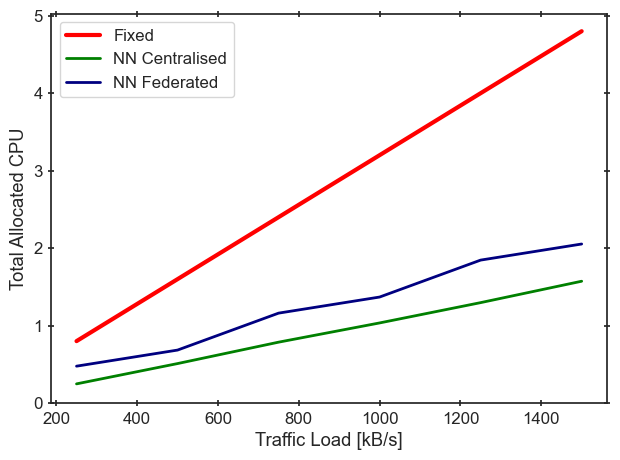

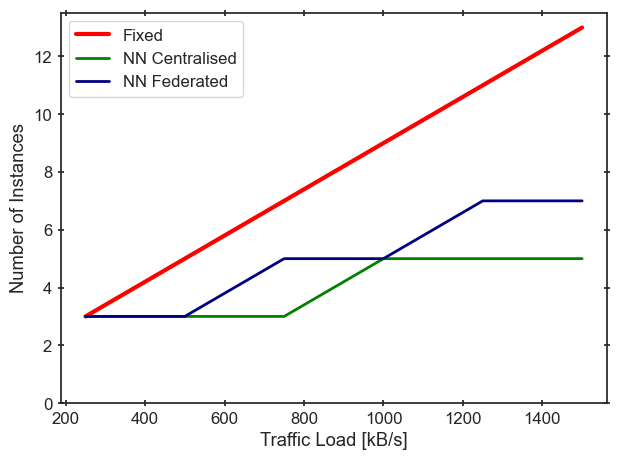

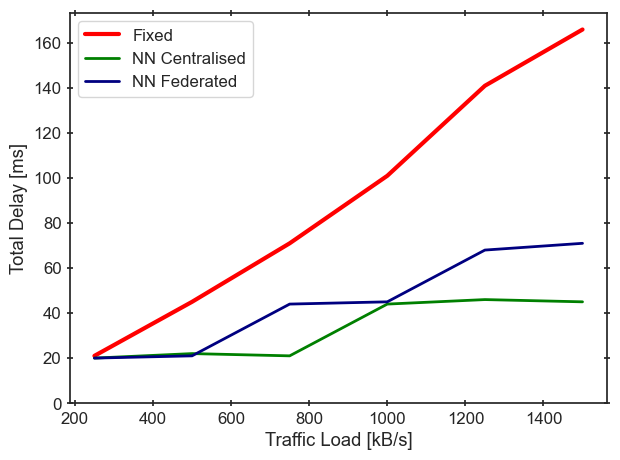

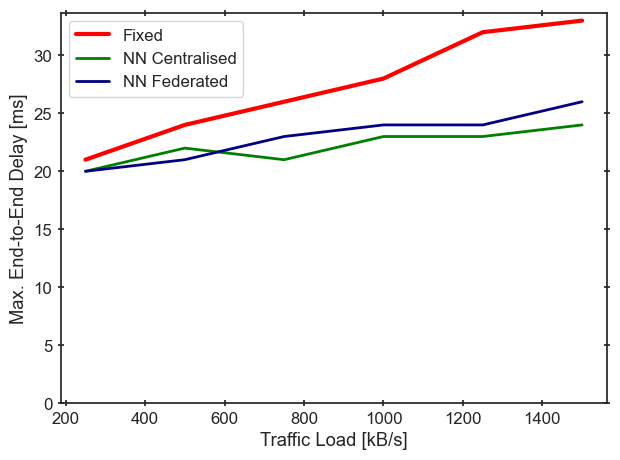

In [143]:
fed_model = 'final_federated_model_adam_adjusted.h5'
fixed_model = 'fixed_0.4'

df_fed = read_results(results + fed_model+'/*.yaml')
df_fixed = read_results(results + fixed_model+'/*.yaml')

for folder in os.listdir(results):
    if folder.startswith('rank'):
        print('operating for folder', folder)
        df_cen = read_results(results + folder+'/*.yaml')
        fig1, _ = plot(df_fed, df_cen, df_fixed, 'source_dr', 'Traffic Load [kB/s]', 'total_cpu', 'Total Allocated CPU', plot_fixed=True)
        fig2, _ = plot(df_fed, df_cen, df_fixed, 'source_dr', 'Traffic Load [kB/s]', 'num_instances', 'Number of Instances', plot_fixed=True)
        fig3, _ = plot(df_fed, df_cen, df_fixed, 'source_dr', 'Traffic Load [kB/s]', 'total_delay', 'Total Delay [ms]', plot_fixed=True)
        fig4, _ = plot(df_fed, df_cen, df_fixed, 'source_dr', 'Traffic Load [kB/s]', 'max_e2e_delay', 'Max. End-to-End Delay [ms]', plot_fixed=True)
        figures = [fig1, fig2, fig3, fig4]
        
        filename = fed_model + "_vs_" + folder +".pdf"  
  
        # call the function
        save_image(os.path.join(plots_folder_path, filename), figures)
        